# Рекомендация тарифов

## Описание проекта

>Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

>В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

>Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Описание данных

 
>- **сalls** — количество звонков,
>- **minutes** — суммарная длительность звонков в минутах,
>- **messages** — количество sms-сообщений,
>- **mb_used** — израсходованный интернет-трафик в Мб,
>- **is_ultra** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


## Оглавление

>[Открытие файла](#id-open) \
>[Разбиение данных на выборки](#id-split)\
>[Исследование моделей](#id-model)\
>[Проверка моделей на тестовой выборке](#id-model-check)

## 1. Откройте и изучите файл <a id="id-open"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


In [5]:
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [6]:
df.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

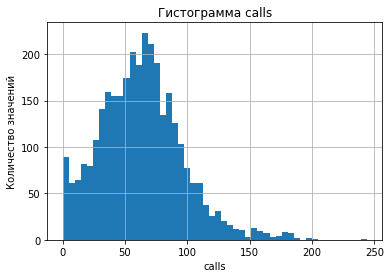

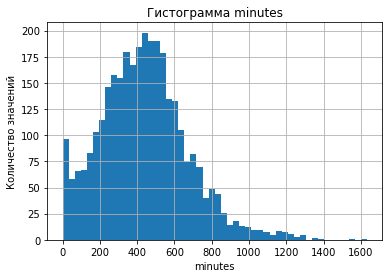

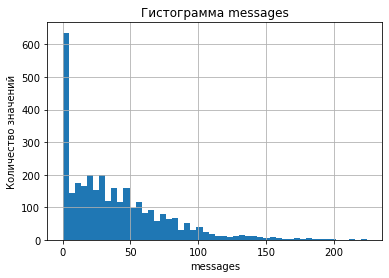

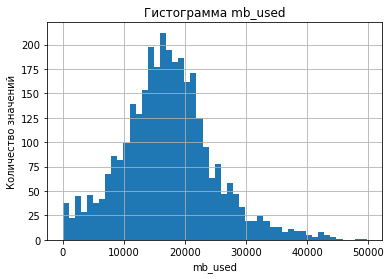

In [7]:
for i in ['calls', 'minutes', 'messages', "mb_used"]:   
    ax = df[i].hist(bins=50)
    ax.set_title("Гистограмма {}".format(i))
    ax.set_xlabel(i)
    ax.set_ylabel("Количество значений")
    plt.show()

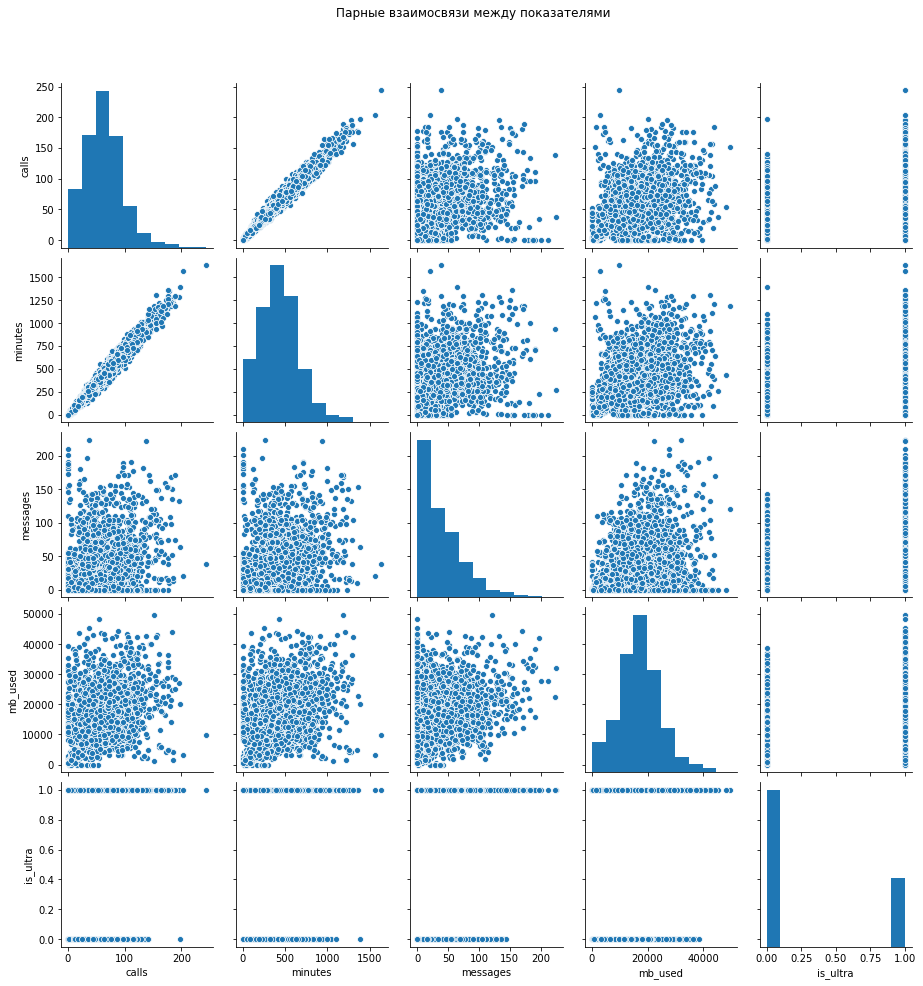

In [8]:
ax = sns.pairplot(df)
ax.fig.suptitle("Парные взаимосвязи между показателями", y=1.08);

In [9]:
df.shape

(3214, 5)

In [10]:
df["is_ultra"].value_counts()[1]/len(df["is_ultra"])*100

30.647168637212197

In [11]:
df["is_ultra"].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

## Вывод

Первый взгляд на исходную таблицу показал следующее:
- В наборе данных 5 переменных  (одна из них целевая) и 3214 наблюдения;
- Данные предобработаны, пустых значений нет;
- 30% значений целевой переменной относятся к одному тарифу, 70% - к другому;
- Исходя из гистограмм можно сказать, что большое количество пользователей не пользуются смс-сообщениями в течение месяца, что похоже на реальный мир:) Также визуально не заметно выбросов (такой же вывод можно сделать исходя из того, что по всем переменным серднее не очень сильно отличается от медианы);
- На парных скаттерплотах видна линейная зависимость между количеством звонков и количеством использованных минут. Регрессия чувствительная к сильно скоррелированным признакам. Поэтому при обучении модели попробуем 2 варианта: 1) оставить оба признака 2) оставить один расчетный признак - средняя длительность звонков.

## 2. Разбейте данные на выборки<a id="id-split"></a>

In [12]:
features = df.drop("is_ultra", axis=1)

In [13]:
target = df["is_ultra"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=47)

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25, random_state=47)

## Вывод

На данном этапе выборку разделили на переменные и целевую переменную, а затем на обучающую, тестовую и валидационную выборки (соотношение 0.6, 0.2, 0.2 соответственно).

## 3. Исследуйте модели<a id="id-model"></a>

### 3.1 Decision tree

In [16]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0 
best_split_tree = 0 
best_leaf_tree = 0

In [17]:
for depth in range(2, 20):
    for split in range(2,20):
        for leaf in range(2, 25):
            model = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, min_samples_leaf=leaf, random_state=47)
            model.fit(X_train, y_train)
            y_valid_pred = model.predict(X_valid)
            result = accuracy_score(y_valid, y_valid_pred)
            if result > best_result_tree:
                best_model_tree = model
                best_result_tree = result
                best_depth_tree = depth
                best_split_tree = split
                best_leaf_tree = leaf

In [18]:
print("\n Показатели лучшей модели:\n\n accuracy:", best_result_tree, 
      "\n", "best max_depth:", best_depth_tree, "\n", "best min_samples_split:", best_split_tree, 
      "\n", "best min_samples_leaf:", best_leaf_tree)


 Показатели лучшей модели:

 accuracy: 0.7947761194029851 
 best max_depth: 8 
 best min_samples_split: 2 
 best min_samples_leaf: 19


### 3.2 Logistic regression

In [19]:
model_logistic = LogisticRegression(random_state=47)
model_logistic.fit(X_train, y_train)
y_valid_pred = model_logistic.predict(X_valid)
result = accuracy_score(y_valid, y_valid_pred)

In [20]:
best_model_logsitic = None
best_result_logistic = 0
best_C = 0

In [21]:
for C in [0.001,0.01,0.1,1,10,100]:
    model = LogisticRegression(random_state=47, C=C)
    model.fit(X_train, y_train)
    y_valid_pred = model.predict(X_valid)
    result = accuracy_score(y_valid, y_valid_pred)
    if result > best_result_logistic:
        best_model_logsitic = model
        best_result_logistic = result
        best_C = C

In [22]:
print("\n Показатели лучшей модели:\n\n accuracy:", best_result_logistic, 
      "\n", "best C:", best_C, "\n")


 Показатели лучшей модели:

 accuracy: 0.7089552238805971 
 best C: 0.001 



Посчитаем среднюю длительность звонков, уберем мультиколлинеарные призанки и посмотрим, повлияет ли это на качество модели.

In [23]:
features["mean_duration"] = features["minutes"]/features["calls"]

In [24]:
features["mean_duration"] = features["mean_duration"].fillna(0)

In [25]:
features = features.drop(["calls", "minutes"], axis=1)

In [26]:
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(features, target, test_size=0.2, random_state=47)

In [27]:
X_train_feat, X_valid_feat, y_train_feat, y_valid_feat = train_test_split(features, target, test_size=0.25, random_state=47)

In [28]:
best_model_logsitic_feat = None
best_result_logistic_feat = 0
best_C_feat = 0

In [29]:
for C in [0.001,0.01,0.1,1,10,100]:
    model = LogisticRegression(random_state=47, C=C)
    model.fit(X_train_feat, y_train_feat)
    y_valid_pred_feat = model.predict(X_valid_feat)
    result = accuracy_score(y_valid_feat, y_valid_pred_feat)
    if result > best_result_logistic:
        best_model_logsitic_feat = model
        best_result_logistic_feat = result
        best_C_feat = C

In [30]:
print("\n Показатели лучшей модели:\n\n accuracy:", best_result_logistic_feat, 
      "\n", "best C:", best_C_feat, "\n")


 Показатели лучшей модели:

 accuracy: 0.7412935323383084 
 best C: 100 



Качество на валидационной выборке улучшилось.

### 3.3 Random Forest

Для Random forеst, чтобы не тратить много времени на работу вложенных циклов, попробуем использовать GridSearchCV. Для этого заново разобъем первоночальную выборку, но на 2 части - обучающую, на которой будет автоматом происходить разбивка на несколько валидационных выборок и тестовую.

In [31]:
X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(features, target, test_size=0.2, 
                                                                                random_state=47)

In [32]:
model = RandomForestClassifier(random_state=47)

In [33]:
param_grid = { 
    'n_estimators': [20, 50, 100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [34]:
clf = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
clf.fit(X_train_forest, y_train_forest)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=47), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [20, 50, 100, 500]})

In [35]:
print("\n Показатели лучшей модели:", clf.best_params_)


 Показатели лучшей модели: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 50}


## Вывод

На валидационной выборке лучший результат среди 2-х алгоритмов (Decision Tree и Logistic Regression) показал Decision Tree. Оценивать качество Random Forest будем на следующем этапе.

## 4. Проверьте модель на тестовой выборке <a id="id-model-check"></a>

### 4.1 Decision tree

In [36]:
y_test_pred_tree = best_model_tree.predict(X_test)

In [37]:
tree_score = accuracy_score(y_test, y_test_pred_tree)

In [38]:
print("\n Accuracy на лучшей модели decision tree на тестовой выборке: ", tree_score)


 Accuracy на лучшей модели decision tree на тестовой выборке:  0.7947122861586314


### 4.2 Logistic regression

In [39]:
y_test_pred_logistic = best_model_logsitic_feat.predict(X_test_feat)

In [40]:
logistic_score = accuracy_score(y_test_feat, y_test_pred_logistic)

In [41]:
print("\n Accuracy на лучшей модели Logistic Regression на тестовой выборке: ", logistic_score)


 Accuracy на лучшей модели Logistic Regression на тестовой выборке:  0.7371695178849145


### 4.3 Random Forest

In [42]:
y_test_pred_forest = clf.predict(X_test_forest)

In [43]:
forest_score = accuracy_score(y_test_forest, y_test_pred_forest)

In [44]:
print("\n Accuracy на лучшей модели Random Forest на тестовой выборке: ", forest_score)


 Accuracy на лучшей модели Random Forest на тестовой выборке:  0.7807153965785381


## Вывод

Лучши показатель accuracy на тестовой выборке показал Desision Tree - 0.795 с параметрами  best max_depth: 8 
 best min_samples_split: 2 
 best min_samples_leaf: 19

Визуализируем результат:

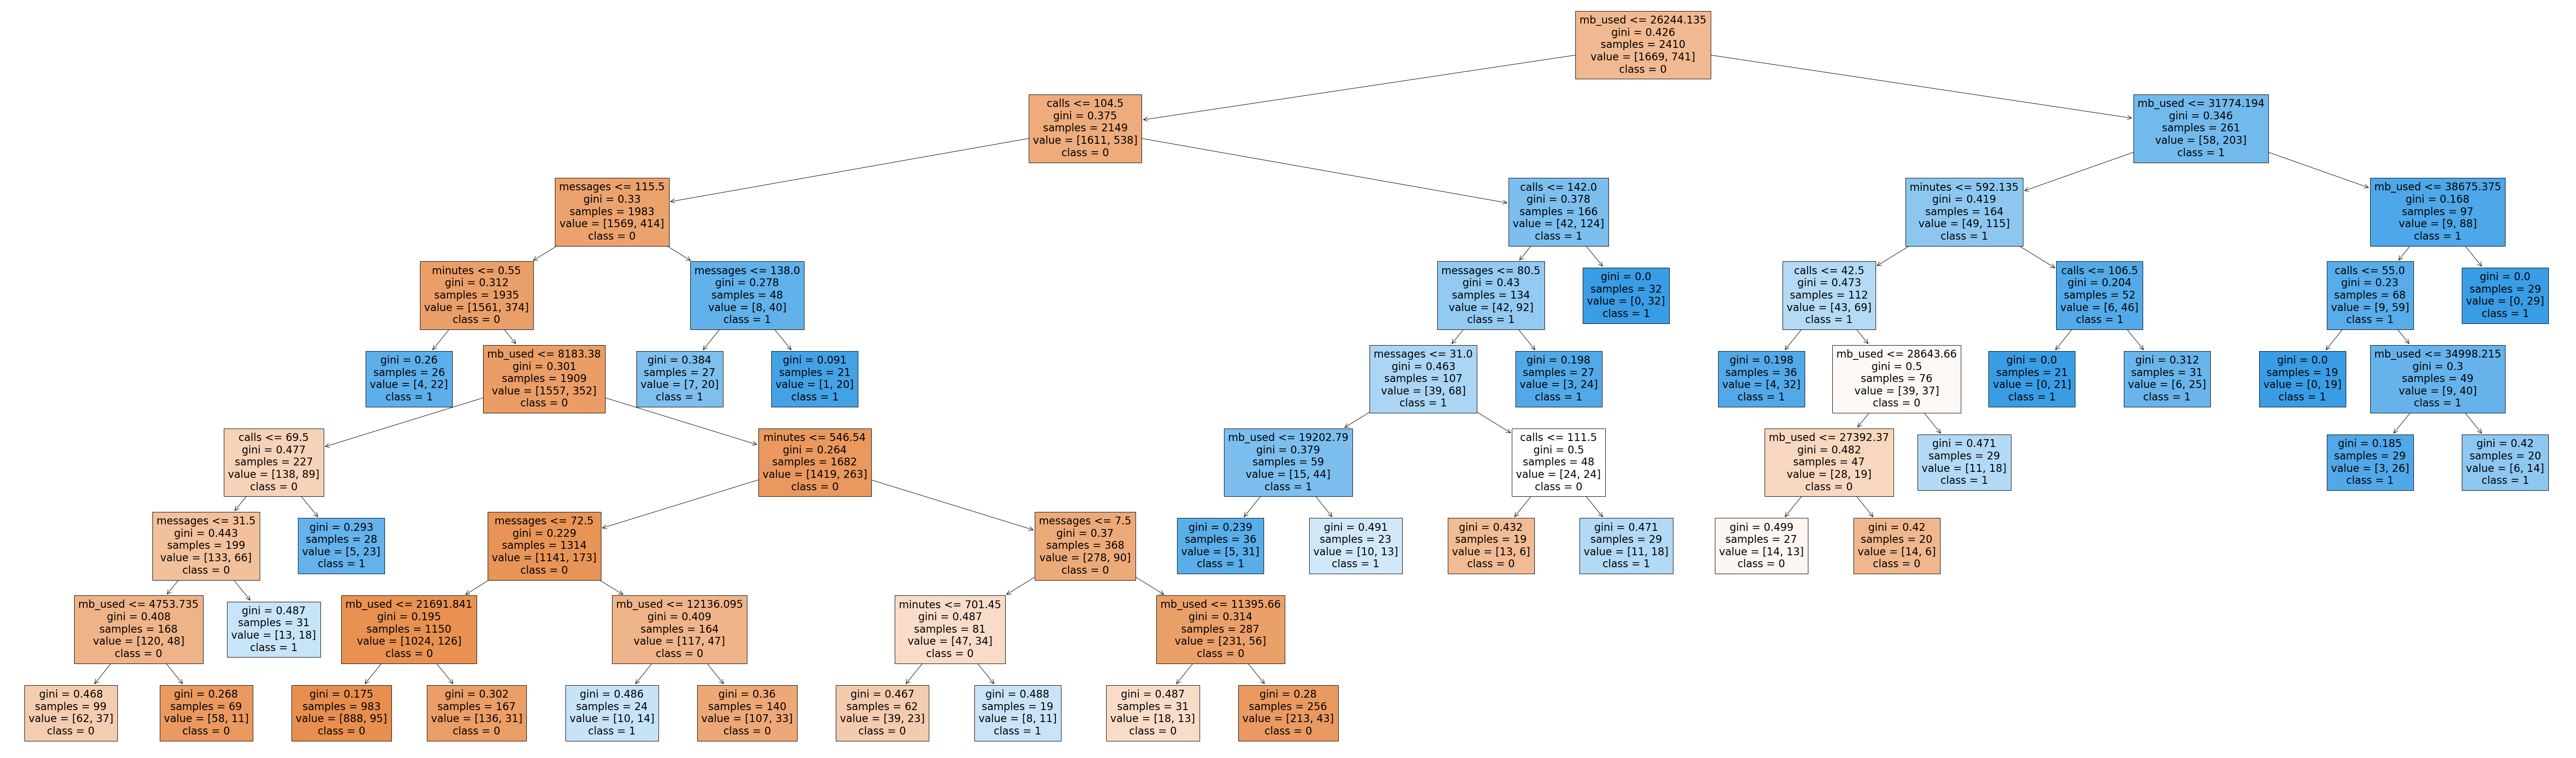

In [45]:
figure(figsize=(100,30))
ax = plot_tree(best_model_tree, feature_names=X_train.columns, filled=True, class_names=["0", "1"]);

## 5. (бонус) Проверьте модели на адекватность

Сравним accuracy нашей модели с моделью, которая всегда предсказывает больший класс - 0.

In [46]:
y_test_simplemodel = pd.Series([0] * 3214)

In [47]:
print("\n Accuracy простой модели: ", accuracy_score(y_test_simplemodel, df["is_ultra"]))


 Accuracy простой модели:  0.693528313627878


## Вывод

Accuracy выбранной лучшей модели Decision Tree выше, чем качество простой модели, которая предсказывает больший класс. Наша модель прошла проверку на адекватность:)

# Главный вывод

- На первом шаге открыли и изучили исходные данные: 5 переменных  (одна из них целевая) и 3214 наблюдения. Классы целевой переменной несбаланисрованы - 30% значений целевой переменной относятся к одному тарифу, 70% - к другому. Обнаружили 2 мультиколлинеарных признака, которые могут негативно сказаться на качестве работы логистической регрессии.
- На втором шаге отделили целевую переменную от остальных и разбили данные на 3 выборки: обучающую, валидационную и тестовую в соотношении 0.6 - 0.2 - 0.2.
- На третьем шаге подобрали гиперпараметры на валидационной выборке и выбрали лучшие модели Decision Tree и Logistic Regression , рассчитали accuracy score. Для Random Forest решили использовать GridSearchCV. Обучили классификатор, выбрали лучшую модель.
- На четвертом шаге предсказали значения целевой переменной на тестовой выборке, рассчитали accuracy score и выбрали лучший алгорим и модель. Лучший алгоритм и модель для данной задачи - Decision Tree с параметрами best max_depth: 8, best min_samples_split: 2, best min_samples_leaf: 19 и accuracy: 0.7947761194029851.
- На последнем этапе представили, что наша модель предсказывает только больший класс, рассчитали для такой модели accuracy и убедились, что выбранная нами модель на предыдущем шаге адекватная.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
